In [1]:
!pip install evaluate torch transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import os
import warnings
import torch
import numpy as np
import librosa
from datasets import Dataset
from transformers import (
    Wav2Vec2ForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoFeatureExtractor,
    DataCollatorWithPadding
)
import evaluate
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
torch.manual_seed(42)

In [3]:
# Suppressing warnings so it looks clean
warnings.filterwarnings("ignore", message="n_fft=1024 is too large for input signal")
warnings.filterwarnings("ignore", message="n_fft=2048 is too large for input signal")
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")
warnings.filterwarnings("ignore", category=UserWarning, module="torch")
warnings.filterwarnings("ignore", message="Some weights of Wav2Vec2ForSequenceClassification were not initialized")
warnings.filterwarnings("ignore", category=UserWarning)

This function, augment_audio, applies two common audio data augmentation techniques: time-stretching and pitch-shifting.

Time-stretching changes the speed of the audio without affecting its pitch. The stretch_factor parameter controls how much faster or slower the audio will be.
Pitch-shifting alters the pitch of the audio by shifting it up or down by a specified number of semitones (pitch_shift_steps).
The function takes in an audio signal (y) and its sample rate (sr), applies both effects in sequence, and returns the modified audio. If any error occurs during the process, it prints an error message and returns the original audio. This can be useful for creating variations of the audio for training machine learning models.

In [4]:
# Function to augment audio (optional, used for data augmentation)
def augment_audio(y, sr, stretch_factor=1.1, pitch_shift_steps=2):
    """
    Perform time-stretch and pitch-shift augmentation on the audio.
    
    Parameters:
        y (numpy.ndarray): Audio signal
        sr (int): Sample rate of the audio
        stretch_factor (float): Factor to stretch the audio
        pitch_shift_steps (int): Number of semitones to shift the pitch
    
    Returns:
        numpy.ndarray: Augmented audio signal
    """
    try:
        # Time Stretch
        y_stretched = librosa.effects.time_stretch(y, rate=stretch_factor)
        # Pitch Shift
        y_pitch_shifted = librosa.effects.pitch_shift(y_stretched, sr=sr, n_steps=pitch_shift_steps)
        return y_pitch_shifted
    except Exception as e:
        print(f"Error in augmentation: {e}")
        return y  # Return original if error occurs

This `preprocess_audio` function loads an audio file, applies some augmentation (time-stretching and pitch-shifting), and ensures the audio has a consistent length. It resamples the audio to 16kHz, applies the augmentations, and then pads or cuts the audio to a maximum length (`max_length`). If anything goes wrong, it catches the error and returns `None`. This is useful for preparing audio data before feeding it into a model.

In [5]:
# Function to extract features from audio files
def preprocess_audio(file_path, max_length=16000, stretch_factor=1.1, pitch_shift_steps=2):
    """
    Load and preprocess an audio file for input to the model.
    
    Parameters:
        file_path (str): Path to the audio file
        max_length (int): Maximum length of the audio in samples
        stretch_factor (float): Time stretch factor for augmentation
        pitch_shift_steps (int): Pitch shift steps for augmentation
    
    Returns:
        numpy.ndarray: Processed audio signal
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=16000)
        # Apply augmentation
        y = augment_audio(y, sr, stretch_factor, pitch_shift_steps)
        # Pad or truncate to max_length
        y = librosa.util.fix_length(y, size=max_length)
        return y
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

The `prepare_dataset_filtered` function loads and processes audio files from specific emotion categories (`target_emotions`). It counts how many files are in each category, extracts features from the audio, and stores them with corresponding labels. Finally, it prints the file counts for each category and the total file count, returning the processed audio data, labels, and category names.

In [6]:
# Updated prepare_dataset function to filter specific emotions and count files
def prepare_dataset_filtered(dataset_path, target_emotions, max_files_per_category = 100):
    """
    Prepare the dataset by extracting features and labels, but only include specific emotions.
    Also, count the total number of files in each target category.

    Parameters:
        dataset_path (str): Path to the dataset folder, organized by subfolders for each category.
        target_emotions (list): List of emotions to include in the dataset.
    
    Returns:
        Tuple: (audio_data, labels, category_names)
    """
    # Get all categories and filter based on the target_emotions list
    categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    filtered_categories = [c for c in categories if c in target_emotions]
    category_dict = {category: idx for idx, category in enumerate(filtered_categories)}
    
    audio_data, labels = [], []
    category_counts = {category: 0 for category in filtered_categories}  # To count files in each category
    
    for category in filtered_categories:
        category_path = os.path.join(dataset_path, category)
        files = [f for f in os.listdir(category_path) if f.endswith(('.wav', '.mp3', '.flac'))]

        # Limit to max_files_per_category files per category
        # files = files[:max_files_per_category]
        
        # Count the number of files in the current category
        category_counts[category] = len(files)
        
        for file in files:
            file_path = os.path.join(category_path, file)
            features = preprocess_audio(file_path)
            if features is not None:
                audio_data.append(features)
                labels.append(category_dict[category])
    
    # Print the file counts for each category and the total count
    total_files = sum(category_counts.values())
    print("File counts per category:")
    for category, count in category_counts.items():
        print(f"{category}: {count} files")
    print(f"Total files: {total_files}")
    
    return np.array(audio_data), np.array(labels), filtered_categories

This code prepares the dataset by specifying the target emotions, loading and filtering the audio data using `prepare_dataset_filtered`, and converting it into a Hugging Face dataset format. The dataset is then split into training, validation, and test sets, with 20% allocated for testing and 10% of the training set reserved for validation. Finally, it prints the shapes of the resulting datasets.

In [7]:
# Specify target emotions
target_emotions = ["Anger", "Happiness", "Sadness", "Neutral"]

# Load dataset
dataset_path = '/kaggle/input/urdu-8emotions-24actors-dataset/normalized'  # Update with your dataset path
audio_data, labels, category_names = prepare_dataset_filtered(dataset_path, target_emotions)

# Convert dataset to Hugging Face format
dataset = Dataset.from_dict({
    "audio": audio_data.tolist(),
    "label": labels
})

# Split dataset into training, validation, and test sets
train_val_dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset, val_dataset = train_val_dataset['train'].train_test_split(test_size=0.1, seed=42).values()
test_dataset = train_val_dataset['test']

print(f"Training dataset shape: {train_dataset.shape}")
print(f"Validation dataset shape: {val_dataset.shape}")
print(f"Test dataset shape: {test_dataset.shape}")

File counts per category:
Neutral: 3479 files
Sadness: 3479 files
Happiness: 3480 files
Anger: 3480 files
Total files: 13918
Training dataset shape: (10020, 2)
Validation dataset shape: (1114, 2)
Test dataset shape: (2784, 2)


In [8]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-xls-r-300m")

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

This `prepare_audio` prepares audio data for the Wav2Vec 2.0 model. It uses the feature extractor to process the audio samples (with a fixed sample rate of 16kHz) and ensures the audio is padded and truncated to a maximum length (`max_length`). The function then renames the input values to match Wav2Vec's expected format and adds the labels to the inputs, returning the preprocessed data ready for model training.

In [9]:
# # Preprocessing function to prepare data for Wav2Vec 2.0
# def preprocess_function(examples, max_length=16000):
#     """
#     Preprocess audio samples for Wav2Vec 2.0.
    
#     Parameters:
#         examples (dict): Dictionary containing audio samples and labels
    
#     Returns:
#         dict: Preprocessed inputs for the model
#     """
#     inputs = feature_extractor(
#         examples["audio"], 
#         sampling_rate=16000, 
#         return_tensors="pt", 
#         padding=True, 
#         truncation=True,
#         max_length=max_length
#     )
#     inputs["labels"] = examples["label"]
#     return inputs
    
# Preprocessing function to prepare data for Wav2Vec 2.0
def prepare_audio(examples, max_length=16000):
    """
    Preprocess audio samples for Wav2Vec 2.0.
    
    Parameters:
        examples (dict): Dictionary containing audio samples and labels
    
    Returns:
        dict: Preprocessed inputs for the model
    """
    # Extract input values using the feature extractor
    inputs = feature_extractor(
        examples["audio"], 
        sampling_rate=16000, 
        return_tensors="pt", 
        padding="max_length", 
        truncation=True,
        max_length=max_length
    )
    # Rename input_values for Trainer compatibility
    inputs["input_values"] = inputs.pop("input_values")
    # Add labels to the inputs
    inputs["labels"] = examples["label"]
    return inputs


This code applies the `prepare_audio` to the training, validation, and test datasets. It processes the audio data into the format required by Wav2Vec 2.0 and removes the original "audio" column since it’s no longer needed after preprocessing. The `batched=True` argument allows processing multiple examples at once, improving efficiency.

In [10]:
train_dataset = train_dataset.map(prepare_audio, batched=True, remove_columns=["audio"])
val_dataset = val_dataset.map(prepare_audio, batched=True, remove_columns=["audio"])
test_dataset = test_dataset.map(prepare_audio, batched=True, remove_columns=["audio"])

Map:   0%|          | 0/10020 [00:00<?, ? examples/s]

Map:   0%|          | 0/1114 [00:00<?, ? examples/s]

Map:   0%|          | 0/2784 [00:00<?, ? examples/s]

This code sets up a Wav2Vec 2.0 model for emotion classification from audio. The **data collator** handles dynamic padding to ensure consistent input lengths in batches. The **model** is loaded for sequence classification, with the number of output labels set to the number of emotions in your dataset. **Evaluation metrics** (accuracy, F1, precision, and recall) are defined to assess the model's performance in classifying emotions.

In [11]:
# Define data collator for dynamic padding
data_collator = DataCollatorWithPadding(feature_extractor)

# Load the Wav2Vec 2.0 model for sequence classification
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    num_labels=len(category_names),
    ignore_mismatched_sizes=True
)

# Define evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The `compute_metrics` function calculates evaluation metrics for model predictions. It computes **accuracy**, **F1 score**, **precision**, and **recall** by comparing the predicted labels (`preds`) with the true labels (`labels`). These metrics are returned in a dictionary for performance assessment.

In [12]:
def compute_metrics(pred):
    """
    Compute evaluation metrics for model predictions.
    
    Parameters:
        pred (PredictionOutput): Predictions and labels from the model
    
    Returns:
        dict: Dictionary of computed metrics
    """
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    precision = precision_metric.compute(predictions=preds, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=preds, references=labels, average="weighted")
    
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"]
    }

In [13]:
# from transformers import TrainerCallback
# from sklearn.metrics import confusion_matrix, accuracy_score
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# class CustomCallback(TrainerCallback):
#     def __init__(self, trainer, test_dataset) -> None:
#         super().__init__()
#         self._trainer = trainer  # Correctly store the trainer
#         self.test_dataset = test_dataset  # Store test_dataset
#         self.true_labels = {'test': []}
#         self.predictions = {'test': []}
    
#     def on_epoch_end(self, args, state, control, **kwargs):
#         if control.should_evaluate:
#             # Perform evaluation for train, eval datasets
#             train_metrics = self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
#             eval_metrics = self._trainer.evaluate(eval_dataset=self._trainer.eval_dataset, metric_key_prefix="eval")
            
#             # Initialize test_metrics as None
#             test_metrics = {'test_loss': 0, 'test_accuracy': 0}
            
#             # Evaluate the test set manually and accumulate predictions and labels
#             if self.test_dataset is not None:
#                 test_predictions = self._trainer.predict(self.test_dataset)
#                 test_metrics['test_loss'] = test_predictions.loss
#                 test_preds = test_predictions.predictions.argmax(axis=1)
#                 test_metrics['test_accuracy'] = accuracy_score(test_predictions.label_ids, test_preds)

#                 # Store the true labels and predictions for the confusion matrix
#                 self.true_labels['test'].extend(test_predictions.label_ids)
#                 self.predictions['test'].extend(test_preds)

#             # Append logs with train, eval, and test metrics
#             state.log_history.append({
#                 'epoch': state.epoch,
#                 'train_loss': train_metrics.get("train_loss", 0),
#                 'train_accuracy': train_metrics.get("train_accuracy", 0),
#                 'eval_loss': eval_metrics.get("eval_loss", 0),
#                 'eval_accuracy': eval_metrics.get("eval_accuracy", 0),
#                 'test_loss': test_metrics['test_loss'],
#                 'test_accuracy': test_metrics['test_accuracy']
#             })

#         return control

#     def on_train_end(self, args, state, control, **kwargs):
#         # Generate and plot the confusion matrix at the end of training
#         if self.true_labels['test'] and self.predictions['test']:
#             # Compute confusion matrix
#             conf_matrix = confusion_matrix(self.true_labels['test'], self.predictions['test'])

#             # Plot confusion matrix
#             plt.figure(figsize=(10, 7))
#             sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=self.test_dataset.features['label'].names, yticklabels=self.test_dataset.features['label'].names)
#             plt.xlabel('Predicted')
#             plt.ylabel('True')
#             plt.title('Confusion Matrix')
#             plt.show()

This code sets up and trains a Wav2Vec 2.0 model. **Training arguments** are defined, specifying settings like batch size, learning rate, number of epochs, and evaluation strategy. A **Trainer** is initialized with the model, datasets, and metrics, then used to train the model. After training, the fine-tuned model is saved to disk.

In [16]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch", 
    num_train_epochs=20,
    per_device_train_batch_size=32,  # Adjust batch size based on GPU memory
    per_device_eval_batch_size=32,
    warmup_steps=300,
    weight_decay=0.01,
    logging_dir="./logs",
    learning_rate=3e-5,
    save_total_limit=3,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    lr_scheduler_type="cosine",
    report_to="none",
    ddp_find_unused_parameters=False # Optimize distributed training (For 2 GPUS)
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# # Initialize custom callback with the test dataset
# custom_callback = CustomCallback(trainer, test_dataset=test_dataset)

# trainer.add_callback(custom_callback)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [17]:
# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./fine_tuned_wav2vec2")

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.345900,1.147210,0.534111,0.462731,0.577501,0.534111
2,1.034400,0.843413,0.655296,0.605961,0.688971,0.655296
3,0.747500,0.578295,0.798923,0.788796,0.797674,0.798923
4,0.579100,0.451631,0.850987,0.849494,0.856849,0.850987
5,0.447400,0.335932,0.887792,0.888238,0.890440,0.887792
6,0.376700,0.291128,0.905745,0.907001,0.910620,0.905745
7,0.307400,0.261406,0.913824,0.913545,0.914794,0.913824
8,0.281000,0.320714,0.882406,0.885565,0.903175,0.882406
9,0.242600,0.229800,0.924596,0.924879,0.927259,0.924596
10,0.212000,0.254574,0.906643,0.909023,0.921143,0.906643


Metrics used

In [18]:
# Evaluate the model on the test set
metrics = trainer.evaluate()
print(f"Test Metrics: {metrics}")

Test Metrics: {'eval_loss': 0.19271400570869446, 'eval_accuracy': 0.9362657091561939, 'eval_f1': 0.9368398685726625, 'eval_precision': 0.9384341358243797, 'eval_recall': 0.9362657091561939, 'eval_runtime': 23.4957, 'eval_samples_per_second': 47.413, 'eval_steps_per_second': 0.766, 'epoch': 20.0}


In [ ]:
# for log in trainer.state.log_history:
#     print(log)

Confusion Matrix

Accuracy: 0.9350


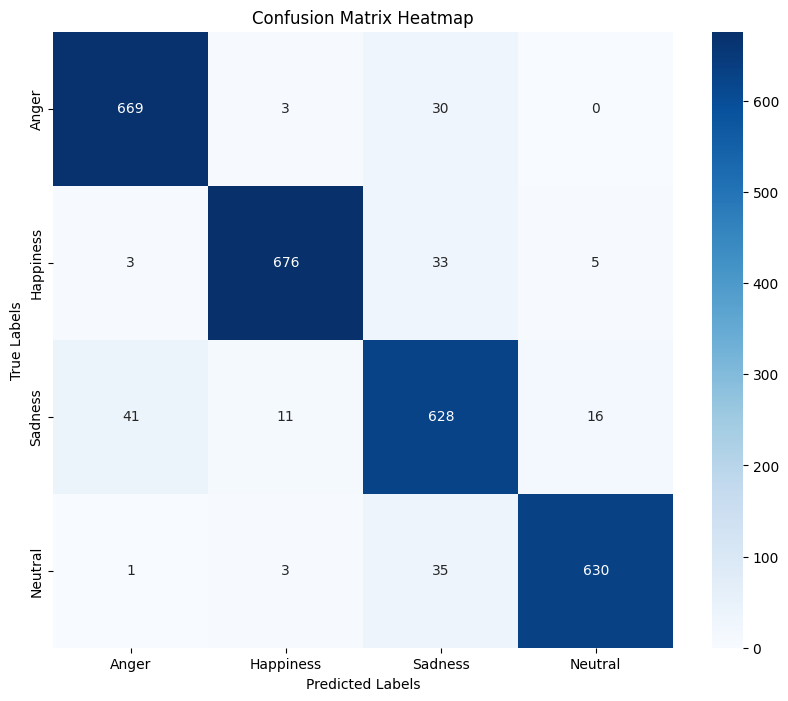

In [19]:
category_names = ["Anger", "Happiness", "Sadness", "Neutral"]

# Extract predictions and true labels
prediction_output = trainer.predict(test_dataset)
y_pred = np.argmax(prediction_output.predictions, axis=1)  # Predicted class labels
y_true = prediction_output.label_ids  # True labels

# Print accuracy
accuracy = prediction_output.metrics.get("test_accuracy", 0)  # Handle metric safely
print(f"Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=category_names, 
    yticklabels=category_names
)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Training and Evaluation loss

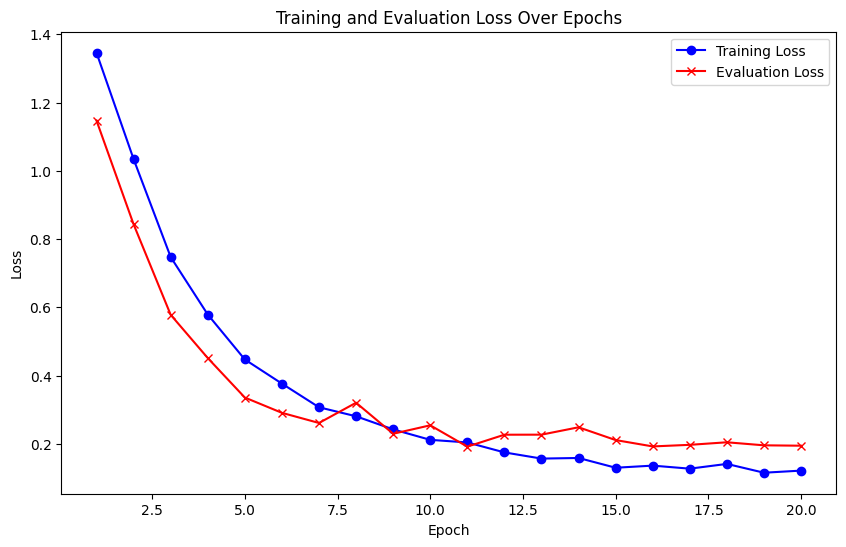

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Training data
train_epochs = [log['epoch'] for log in trainer.state.log_history if 'loss' in log]
train_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]

# Evaluation data
eval_epochs = [log['epoch'] for log in trainer.state.log_history if 'eval_loss' in log]
eval_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Aggregate evaluation loss to match training epochs (average for each epoch)
agg_eval_losses = []
epoch_start = 0

for epoch in range(1, len(train_epochs) + 1):
    # Find all evaluation losses that correspond to the current epoch
    epoch_end = epoch_start
    while epoch_end < len(eval_epochs) and eval_epochs[epoch_end] == epoch:
        epoch_end += 1
    
    # Calculate the average of evaluation losses for the current epoch
    epoch_losses = eval_losses[epoch_start:epoch_end]
    agg_eval_losses.append(np.mean(epoch_losses))
    
    # Update the index for the next epoch
    epoch_start = epoch_end

# Now we plot the training and aggregated evaluation loss
plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(train_epochs, train_losses, label='Training Loss', color='blue', marker='o')

# Plot Aggregated Evaluation Loss
plt.plot(range(1, len(agg_eval_losses) + 1), agg_eval_losses, label='Evaluation Loss', color='red', marker='x')

# Set plot labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Epochs')

# Show legend
plt.legend()

# Display the plot
plt.show()

Evaluation Accuracy

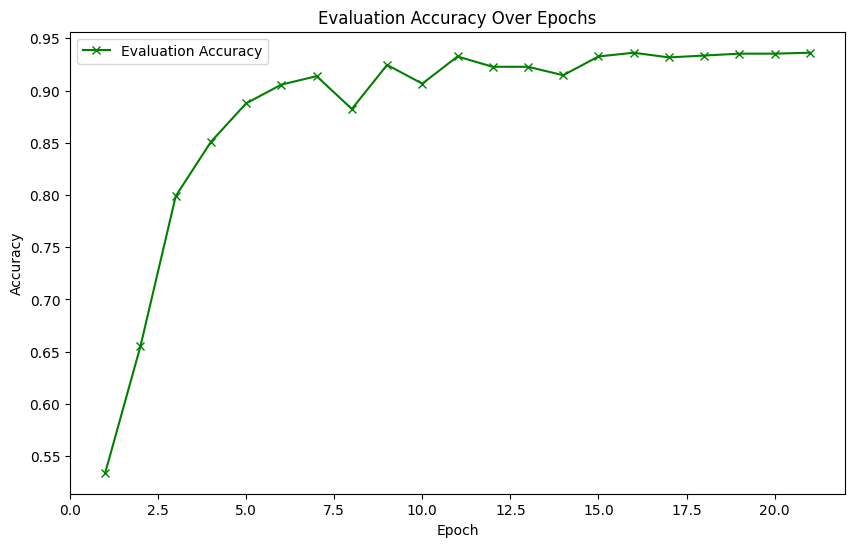

In [21]:
eval_accuracies = [log['eval_accuracy'] for log in trainer.state.log_history if 'eval_accuracy' in log]

# Plot Evaluation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eval_accuracies) + 1), eval_accuracies, label='Evaluation Accuracy', color='green', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy Over Epochs')
plt.legend()
plt.show()

F1, Precision and Recall scores

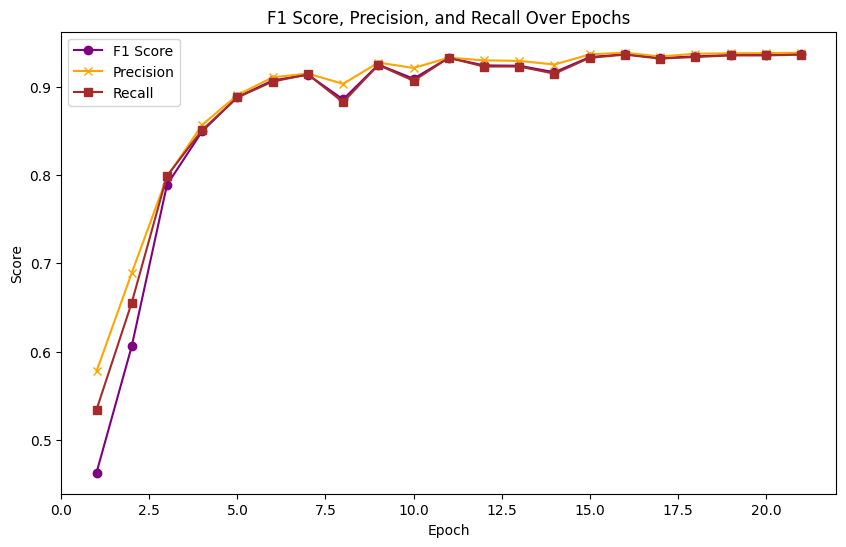

In [22]:
eval_f1 = [log['eval_f1'] for log in trainer.state.log_history if 'eval_f1' in log]
eval_precision = [log['eval_precision'] for log in trainer.state.log_history if 'eval_precision' in log]
eval_recall = [log['eval_recall'] for log in trainer.state.log_history if 'eval_recall' in log]

# Plot F1 Score, Precision, and Recall
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eval_f1) + 1), eval_f1, label='F1 Score', color='purple', marker='o')
plt.plot(range(1, len(eval_precision) + 1), eval_precision, label='Precision', color='orange', marker='x')
plt.plot(range(1, len(eval_recall) + 1), eval_recall, label='Recall', color='brown', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('F1 Score, Precision, and Recall Over Epochs')
plt.legend()
plt.show()